# Association Rules Mining / Basket Analysis

Basket Analysis (BA) is a powerful technique to mining the assocation between items within a basket, the result could be communicated as **Frequently Bought Together** items, that is used to:

- Create the bundle of items
- Recommend other items to add to basket (as "Frequently Bought Togther")

BA is recommendation algorithm, but not personalization, as it is item-based, and not personalize the recommend by user.

**The interesting of this hands-on**:

- Instead of using any available public dataset, we will generate the synthetic data, by that:
    - We understand deeply the data structure used for this model
    - We can validate if the output make sense or not
- Instead of using the existing Python package (such as: `mlxtend.frequent_patterns`), we will code the logic of Apriori Algorithm by our own, _it is the best way to understand the model in deeper level_



In [597]:
import os
import sys
from typing import Dict
from numpy.random import choice, randint
from itertools import groupby
import pandas as pd
import pytest
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import string
from graphviz import Digraph

# Create basket synthetic data

Structure of data input for basket analysis:

- basket_1: apple, egg, cheese
- basket_2: egg, bread
- basket_3: bread, cheese
- basket_4: apple, orange
- basket_5: egg, cheese

In [509]:
def create_basket(list_item: list, init_freq: list, n_basket: int) -> Dict:
    """Create a basket of items.
    Args:
        list_item (list): list of items ['beer', 'egg', 'cheese', 'bread']
        init_freq (list): initial frequency of items [0.2, 0.3, 0.1, 0.4]
    Returns:
        Dict with items as key, and 
    """
    baskets = {}
    for basket_id in range(n_basket):
        baskets[basket_id] = choice(list_item, p=init_freq)
    return baskets

In [515]:
baskets_dict = create_basket(list_item=['beer', 'egg', 'cheese', 'bread', 'wine', 'apple', 'orange'],
             init_freq=[0.2, 0.05, 0.1, 0.3, 0.05, 0.2, 0.1],
             n_basket=1000)

In [562]:
associated_rules = {'bread': {'egg': 0.3, 'cheese': 0.2},
                    'egg': {'apple': 0.2},
                    'cheese': {'egg': 0.3},
                    'beer': {'cheese': 0.2, 'wine': 0.5},
                    'apple': {'orange': 0.2}
                   }

associated_rules

{'bread': {'egg': 0.3, 'cheese': 0.2},
 'egg': {'apple': 0.2},
 'cheese': {'egg': 0.3},
 'beer': {'cheese': 0.2, 'wine': 0.5},
 'apple': {'orange': 0.2}}

In [563]:
def generate_next_items_by_associated_rule(item, associated_rules, synthetic_item_list):
    try:
        associated_items = list(associated_rules[item].keys())
        associated_items_freqs = list(associated_rules[item].values())
        other_items = [i for i in synthetic_item_list if i not in [item, *associated_items]]
        other_freq = (1 - np.sum(associated_items_freqs)) / len(other_items)
        other_freqs = np.repeat(other_freq, len(other_items)-1)
        next_item = choice([*associated_items, *other_items], 
                           p=[*associated_items_freqs, 
                              *other_freqs, 
                              1. - np.sum(associated_items_freqs) - np.sum(other_freqs)])
    except:
        other_items = [i for i in synthetic_item_list if i != item]
        next_item = choice(other_items)
    return next_item

In [564]:
for item in synthetic_item_list:
    next_item = generate_associated_items_by_rule(item, associated_rules, synthetic_item_list)
    print(f'{item} ==> {next_item}')

beer ==> wine
egg ==> bread
cheese ==> orange
bread ==> apple
wine ==> egg
apple ==> beer
orange ==> apple


In [565]:
# Create synthetic
basket_df = pd.DataFrame({
    'basket_id': baskets_dict.keys(),
    'items_list': [[item] for item in baskets_dict.values()],
    'size_basket': randint(low=2, high=4, size=1000, dtype=int)
})
for i in range(basket_df.size_basket.max()):
    basket_df['items_list'] = basket_df.items_list.apply(lambda x: [*x, generate_associated_items_by_rule(x[-1], associated_rules, synthetic_item_list)])

basket_df['items_list'] = basket_df.items_list.apply(lambda x: list(dict.fromkeys(x))) # dedup
basket_df['items_list'] = basket_df.apply(lambda r: r.items_list[:r.size_basket], axis=1)
basket_df['item_pairs'] = basket_df.items_list.apply(lambda x: list(combinations(x, 2)))

In [566]:
basket_df

,basket_id,items_list,size_basket,item_pairs
0,0,"[egg, bread]",2,"[(egg, bread)]"
1,1,"[apple, beer, egg]",3,"[(apple, beer), (apple, egg), (beer, egg)]"
2,2,"[apple, bread, cheese]",3,"[(apple, bread), (apple, cheese), (bread, chee..."
3,3,"[bread, egg, beer]",3,"[(bread, egg), (bread, beer), (egg, beer)]"
4,4,"[beer, wine]",2,"[(beer, wine)]"
...,...,...,...,...
995,995,"[beer, wine, orange]",3,"[(beer, wine), (beer, orange), (wine, orange)]"
996,996,"[beer, wine]",2,"[(beer, wine)]"
997,997,"[beer, wine, egg]",3,"[(beer, wine), (beer, egg), (wine, egg)]"
998,998,"[beer, wine, orange]",3,"[(beer, wine), (beer, orange), (wine, orange)]"


In [567]:
df_item_line = (basket_df[['basket_id', 'items_list', 'size_basket']]
                .explode('items_list')
                .rename(columns={'items_list': 'item_name'})
               )
df_item_support = df_item_line.groupby('item_name').basket_id.nunique().rename('occurence').reset_index() 
df_item_support['item_support'] = df_item_support.occurence / df_item_support.occurence.sum()
df_item_support

,item_name,occurence,item_support
0,apple,358,0.145351
1,beer,340,0.138043
2,bread,459,0.186358
3,cheese,347,0.140885
4,egg,327,0.132765
5,orange,315,0.127893
6,wine,317,0.128705


In [568]:
df_item_pairs = basket_df[['basket_id', 'item_pairs']].explode('item_pairs')
df_item_pairs = df_item_pairs.groupby('item_pairs').basket_id.nunique().rename('occurence_AB').reset_index()

In [569]:
# df_item_pairs[df_item_pairs.itemA == df_item_pairs.itemB]

In [570]:
# Filter by min occurance of item_pairs
min_occurence_AB = 30 
print(f'Before: {df_item_pairs.shape}')
df_item_pairs = df_item_pairs[df_item_pairs.occurence_AB >= min_occurence_AB]
print(f'After: {df_item_pairs.shape}')

Before: (42, 2)
After: (32, 2)


In [571]:
df_item_pairs['itemA'] = df_item_pairs.item_pairs.apply(lambda x: x[0])
df_item_pairs['itemB'] = df_item_pairs.item_pairs.apply(lambda x: x[1])
df_item_pairs = pd.merge(
    df_item_pairs, 
    df_item_support[['item_name', 'item_support']].rename(columns={'item_name':'itemA', 'item_support':'supportA'})
)
df_item_pairs = pd.merge(
    df_item_pairs, 
    df_item_support[['item_name', 'item_support']].rename(columns={'item_name':'itemB', 'item_support':'supportB'})
)

df_item_pairs.head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB
0,"(apple, beer)",57,apple,beer,0.145351,0.138043
1,"(bread, beer)",71,bread,beer,0.186358,0.138043
2,"(cheese, beer)",42,cheese,beer,0.140885,0.138043
3,"(orange, beer)",33,orange,beer,0.127893,0.138043
4,"(apple, bread)",55,apple,bread,0.145351,0.186358


In [572]:
# support{apple,egg} = 3/5 or 60%
df_item_pairs['support_AB'] = df_item_pairs.occurence_AB / df_item_pairs.occurence_AB.sum()
df_item_pairs.sort_values(by='support_AB', ascending=False).head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905
18,"(bread, orange)",82,bread,orange,0.186358,0.127893,0.048636
24,"(bread, wine)",72,bread,wine,0.186358,0.128705,0.042705


In [573]:
# confidence{A->B} = support{A,B} / support{A}   
df_item_pairs['confidence_AB'] = df_item_pairs.support_AB / df_item_pairs.supportA
df_item_pairs['confidence_BA'] = df_item_pairs.support_AB / df_item_pairs.supportB
df_item_pairs.sort_values(by='support_AB', ascending=False).head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733,0.541375,0.580655
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174,0.381923,0.536093
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905,0.321452,0.425205
18,"(bread, orange)",82,bread,orange,0.186358,0.127893,0.048636,0.260980,0.380286
24,"(bread, wine)",72,bread,wine,0.186358,0.128705,0.042705,0.229154,0.331803


In [574]:
# lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B}) 
df_item_pairs['lift'] = df_item_pairs.support_AB / (df_item_pairs.supportA * df_item_pairs.supportB)
df_item_pairs.sort_values(by='support_AB', ascending=False).head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733,0.541375,0.580655,4.206333
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174,0.381923,0.536093,2.876683
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905,0.321452,0.425205,2.281658
18,"(bread, orange)",82,bread,orange,0.186358,0.127893,0.048636,0.260980,0.380286,2.040619
24,"(bread, wine)",72,bread,wine,0.186358,0.128705,0.042705,0.229154,0.331803,1.780458


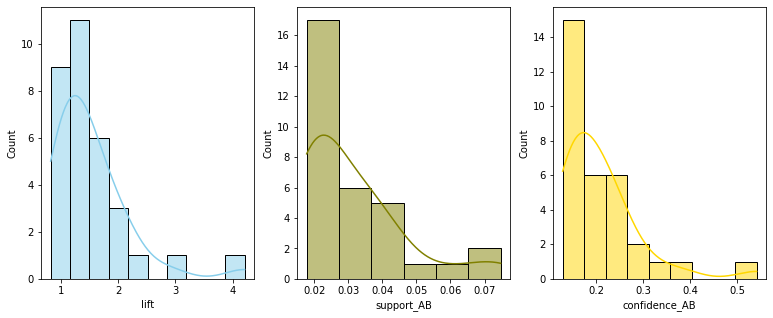

In [575]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))

xs = ['lift', 'support_AB', 'confidence_AB']
colors = ['skyblue', 'olive', 'gold']

for i in range(3):
    sns.histplot(data=df_item_pairs, x=xs[i], kde=True, color=colors[i], ax=axs[i])

In [576]:
# Choise of support/confidence
# Source: https://www.kaggle.com/code/xvivancos/market-basket-analysis/report
# Lower the support: Having more rules, with high confidence level
rules = df_item_pairs#[df_item_pairs.support_AB >= 0.01]
def plot_numrules_confidence_lvl(df_item_pairs, min_support, ax):
    rules_df = df_item_pairs[df_item_pairs.support_AB >= min_support]
    confidence_levels = np.arange(0, 1, 0.1)
    num_rules = []
    for thres_lvl in confidence_levels:
        rule_cnt = rules_df[rules_df.confidence_AB > thres_lvl].shape[0]
        num_rules.append(rule_cnt)
    
    df_confidence_rule_cnt = pd.DataFrame({
        'confidence_level': confidence_levels,
        'num_rules': num_rules
    }).set_index('confidence_level')
    
    ax.plot(confidence_levels, num_rules, 'o-', color='black')
    ax.set_title(f'Cut-off: support_AB >= {min_support}')
    ax.set_xlabel('Confidence level')
    return ax

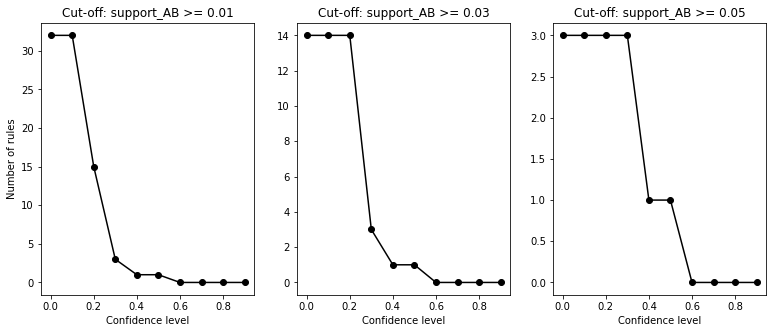

In [577]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
min_support = [0.01, 0.03, 0.05]
for i in range(3):
    plot_numrules_confidence_lvl(df_item_pairs, min_support=min_support[i], ax=axs[i])
    if i == 0:
        axs[i].set_ylabel('Number of rules')

In [584]:
df_item_pairs_flr_support = df_item_pairs[df_item_pairs.support_AB >= 0.01]
df_item_pairs_flr_support_confi = df_item_pairs_flr_support[df_item_pairs_flr_support.confidence_AB >= 0.2]
print(df_item_pairs.shape)
print(df_item_pairs_flr_support.shape)
print(df_item_pairs_flr_support_confi.shape)

(32, 10)
(32, 10)
(15, 10)


In [585]:
# lift = 1 implies no relationship between A and B. 
# (ie: A and B occur together only by chance)
df_item_pairs[df_item_pairs.lift.between(0.9, 1.1)].head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift
10,"(orange, cheese)",30,orange,cheese,0.127893,0.140885,0.017794,0.139129,0.126299,0.987535
12,"(beer, egg)",30,beer,egg,0.138043,0.132765,0.017794,0.128899,0.134023,0.970881
27,"(beer, apple)",31,beer,apple,0.138043,0.145351,0.018387,0.133196,0.126499,0.916370
29,"(cheese, apple)",32,cheese,apple,0.140885,0.145351,0.018980,0.134719,0.130579,0.926848
31,"(wine, apple)",31,wine,apple,0.128705,0.145351,0.018387,0.142860,0.126499,0.982858


In [586]:
df_item_pairs_flr_support_confi[df_item_pairs_flr_support_confi.lift.between(0.9, 1.1)].shape

(0, 10)

In [587]:
# lift > 1 implies that there is a positive relationship between A and B.
# (ie:  A and B occur together more often than random)
df_item_pairs_flr_support_confi.sort_values(by='lift', ascending=False).head()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733,0.541375,0.580655,4.206333
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174,0.381923,0.536093,2.876683
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905,0.321452,0.425205,2.281658
14,"(cheese, egg)",67,cheese,egg,0.140885,0.132765,0.039739,0.282067,0.299319,2.124559
16,"(apple, orange)",66,apple,orange,0.145351,0.127893,0.039146,0.269319,0.306084,2.105822


In [588]:
df_item_pairs_flr_support_confi.sort_values(by='lift', ascending=False).tail()

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift
11,"(apple, egg)",53,apple,egg,0.145351,0.132765,0.031435,0.216272,0.236775,1.628982
7,"(apple, cheese)",54,apple,cheese,0.145351,0.140885,0.032028,0.220352,0.227338,1.564057
8,"(beer, cheese)",49,beer,cheese,0.138043,0.140885,0.029063,0.210535,0.206288,1.494373
28,"(bread, apple)",63,bread,apple,0.186358,0.145351,0.037367,0.200509,0.257078,1.379482
4,"(apple, bread)",55,apple,bread,0.145351,0.186358,0.032622,0.224433,0.175048,1.204310


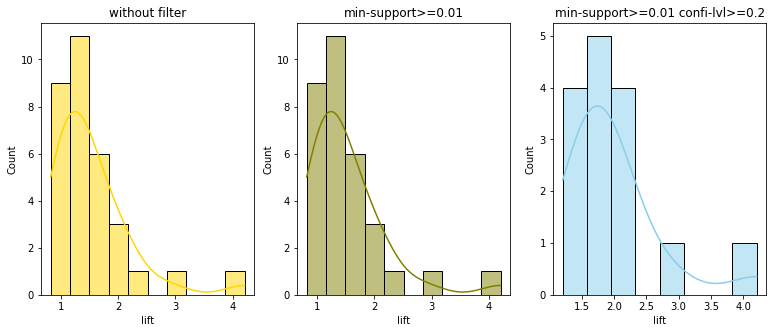

In [589]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))

xs = ['lift', 'support_AB', 'confidence_AB']
colors = ['skyblue', 'olive', 'gold']

tit1 = 'without filter'
tit2 = 'min-support>=0.01'
tit3 = tit2 + ' ' + 'confi-lvl>=0.2'

sns.histplot(data=df_item_pairs, x='lift', kde=True, color='gold', ax=axs[0]).set(title=tit1)
sns.histplot(data=df_item_pairs_flr_support, x='lift', kde=True, color='olive', ax=axs[1]).set(title=tit2)
sns.histplot(data=df_item_pairs_flr_support_confi, x='lift', kde=True, color='skyblue', ax=axs[2]).set(title=tit3);

In [590]:
df_apriori = df_item_pairs_flr_support_confi.sort_values(by='lift', ascending=False)
df_apriori

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733,0.541375,0.580655,4.206333
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174,0.381923,0.536093,2.876683
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905,0.321452,0.425205,2.281658
14,"(cheese, egg)",67,cheese,egg,0.140885,0.132765,0.039739,0.282067,0.299319,2.124559
16,"(apple, orange)",66,apple,orange,0.145351,0.127893,0.039146,0.269319,0.306084,2.105822
18,"(bread, orange)",82,bread,orange,0.186358,0.127893,0.048636,0.260980,0.380286,2.040619
22,"(apple, wine)",57,apple,wine,0.145351,0.128705,0.033808,0.232594,0.262677,1.807190
24,"(bread, wine)",72,bread,wine,0.186358,0.128705,0.042705,0.229154,0.331803,1.780458
0,"(apple, beer)",57,apple,beer,0.145351,0.138043,0.033808,0.232594,0.244908,1.684939
1,"(bread, beer)",71,bread,beer,0.186358,0.138043,0.042112,0.225971,0.305061,1.636960


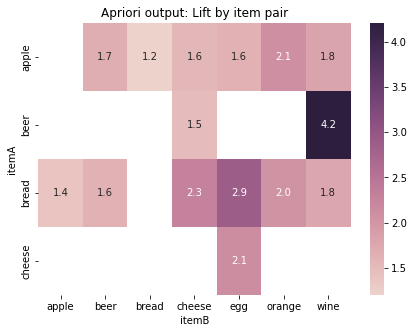

In [591]:
df_heatmap = (df_apriori
              .groupby(['itemA', 'itemB']).lift.mean()
              .reset_index()
              .pivot(index='itemA', columns='itemB', values='lift')
             )
plt.figure(figsize=(7, 5))
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Apriori output: Lift by item pair');

In [592]:
df_apriori = df_apriori[df_apriori.lift >= 1.3]

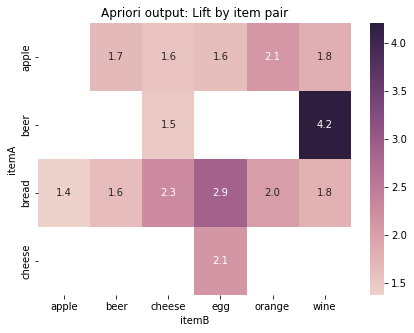

In [593]:
df_heatmap = (df_apriori
              .groupby(['itemA', 'itemB']).lift.mean()
              .reset_index()
              .pivot(index='itemA', columns='itemB', values='lift')
             )
plt.figure(figsize=(7, 5))
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Apriori output: Lift by item pair');

In [594]:
# Create nodes_df
associated_items_ls = pd.concat([df_apriori.itemA, df_apriori.itemB]).unique()
nodes_df = df_item_support[df_item_support.item_name.isin(associated_items_ls)]

alphanum_nodeid = list(string.ascii_lowercase) + [str(i) for i in range(9)]
nodes_df['node_id'] = [alphanum_nodeid[i] for i in range(len(nodes_df))]
nodes_df

,item_name,occurence,item_support,node_id
0,apple,358,0.145351,a
1,beer,340,0.138043,b
2,bread,459,0.186358,c
3,cheese,347,0.140885,d
4,egg,327,0.132765,e
5,orange,315,0.127893,f
6,wine,317,0.128705,g


In [595]:
# Add node_id to df_apriori
nodes_id_dict = {r.item_name: r.node_id for _, r in nodes_df.iterrows()}
df_apriori['from_node_id'] = df_apriori.itemA.apply(lambda x: nodes_id_dict[x])
df_apriori['to_node_id'] = df_apriori.itemB.apply(lambda x: nodes_id_dict[x])
df_apriori['edge'] = df_apriori.from_node_id + df_apriori.to_node_id
df_apriori

/var/folders/tn/xpr0bd8x39d87tc_djfk2p2w0000gn/T/ipykernel_24449/2649525621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apriori['from_node_id'] = df_apriori.itemA.apply(lambda x: nodes_id_dict[x])
/var/folders/tn/xpr0bd8x39d87tc_djfk2p2w0000gn/T/ipykernel_24449/2649525621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apriori['to_node_id'] = df_apriori.itemB.apply(lambda x: nodes_id_dict[x])
/var/folders/tn/xpr0bd8x39d87tc_djfk2p2w0000gn/T/ipykernel_24449/2649525621.py:5: SettingWithCopyW

,item_pairs,occurence_AB,itemA,itemB,supportA,supportB,support_AB,confidence_AB,confidence_BA,lift,from_node_id,to_node_id,edge
23,"(beer, wine)",126,beer,wine,0.138043,0.128705,0.074733,0.541375,0.580655,4.206333,b,g,bg
13,"(bread, egg)",120,bread,egg,0.186358,0.132765,0.071174,0.381923,0.536093,2.876683,c,e,ce
9,"(bread, cheese)",101,bread,cheese,0.186358,0.140885,0.059905,0.321452,0.425205,2.281658,c,d,cd
14,"(cheese, egg)",67,cheese,egg,0.140885,0.132765,0.039739,0.282067,0.299319,2.124559,d,e,de
16,"(apple, orange)",66,apple,orange,0.145351,0.127893,0.039146,0.269319,0.306084,2.105822,a,f,af
18,"(bread, orange)",82,bread,orange,0.186358,0.127893,0.048636,0.260980,0.380286,2.040619,c,f,cf
22,"(apple, wine)",57,apple,wine,0.145351,0.128705,0.033808,0.232594,0.262677,1.807190,a,g,ag
24,"(bread, wine)",72,bread,wine,0.186358,0.128705,0.042705,0.229154,0.331803,1.780458,c,g,cg
0,"(apple, beer)",57,apple,beer,0.145351,0.138043,0.033808,0.232594,0.244908,1.684939,a,b,ab
1,"(bread, beer)",71,bread,beer,0.186358,0.138043,0.042112,0.225971,0.305061,1.636960,c,b,cb


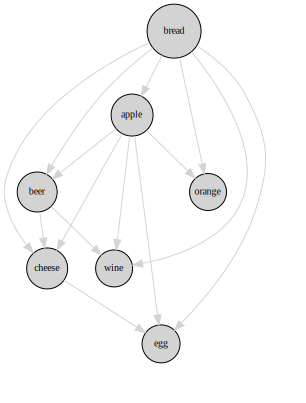

In [596]:
scaled_size = 4
gra = Digraph(edge_attr={'color':'lightgray'},
              node_attr={'shape': 'circle', 'fixedsize':'true', 'style': 'filled', 'fontsize': '10'},
              graph_attr={'beautify':'true', 'margin': '0.5'},
              format='pdf'
             )

for _, r in nodes_df.iterrows():
    gra.node(r.node_id, r.item_name.lower(), **{'width':str(r.item_support * scaled_size)})

gra.edges(df_apriori.edge.tolist())
gra